# <font color='violet'>Exploration of a Single User</font>

eda1 link: https://github.com/fractaldatalearning/Capstone2/blob/main/notebooks/eda1_w_data_direct_from_wrangling.ipynb

In eda1 I was exploring data as-is right after basic wrangling/cleaning. I'll definitely need more rows and columns, and this notebook is for figuring out how to create new rows that indicate for each order where there's a non-order of a previously-ordered item. Starting with just one user. 

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

import itertools
from library.sb_utils import save_file
import json

In [2]:
df = pd.read_csv('../data/processed/full_data_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33819106 entries, 0 to 33819105
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   order_by_user_sequence  int64  
 3   order_dow               int64  
 4   order_hour_of_day       int64  
 5   days_since_prior_order  float64
 6   product_id              int64  
 7   add_to_cart_sequence    int64  
 8   reordered               int64  
 9   product_name            object 
 10  aisle_name              object 
 11  dept_name               object 
 12  aisle_id                int64  
 13  department_id           int64  
 14  eval_set                object 
dtypes: float64(1), int64(10), object(4)
memory usage: 3.8+ GB


**<font color='violet'>Find just one user to explore with.</font>**

In [3]:
prolific_users = df[df['order_by_user_sequence']>100]
len(prolific_users['user_id'].unique())

0

In [4]:
prolific_users = df[df['order_by_user_sequence']==100]
len(prolific_users['user_id'].unique())

867

In [5]:
prolific_users['add_to_cart_sequence'].max()

47

In [6]:
prolific_user_w_biggest_cart = prolific_users[prolific_users['add_to_cart_sequence']==47]
prolific_user_w_biggest_cart

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,aisle_id,department_id,eval_set
5263305,1629423,32099,100,1,14,1.0,27966,47,1,Organic Raspberries,packaged vegetables fruits,produce,123,4,train


In [7]:
practice_user = df[df['user_id']==32099]
practice_user.sample(7)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,aisle_id,department_id,eval_set
5261926,3380792,32099,24,6,12,7.0,43961,16,1,Organic Peeled Whole Baby Carrots,packaged vegetables fruits,produce,123,4,prior
5262559,1690282,32099,57,1,10,5.0,45840,40,1,100% Pure Apple Juice,juice nectars,beverages,98,7,prior
5261996,1878425,32099,28,6,12,2.0,6286,3,0,Half and Half,cream,dairy eggs,53,16,prior
5263038,970868,32099,84,5,14,9.0,2390,15,1,Pita Crisps Simply Naked,chips pretzels,snacks,107,19,prior
5263165,1613797,32099,92,4,16,4.0,49105,4,1,Classic with Tuna Anchovies & Whitefish Cat Food,cat food care,pets,41,8,prior
5263015,2765929,32099,82,2,11,1.0,13245,3,1,"Natural Artesian Water, Mini & Mobile",water seltzer sparkling water,beverages,115,7,prior
5261702,1990534,32099,15,0,10,3.0,39322,31,0,Caramel Almond and Sea Salt Nut Bar,energy granola bars,snacks,3,19,prior


In [8]:
# Save version of this df before adding new rows
pu_unchanged = practice_user
pu_unchanged.head(2)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,aisle_id,department_id,eval_set
5261360,2959648,32099,1,0,17,NaN,40285,18,0,Traditional Snack Mix,trail mix snack mix,snacks,125,19,prior
5261361,2959648,32099,1,0,17,NaN,27966,15,0,Organic Raspberries,packaged vegetables fruits,produce,123,4,prior


**<font color='violet'>Tease out whether each item is reordered or not each order.</font>**

In [9]:
order1 = practice_user[practice_user['order_by_user_sequence']==1
                           ]['product_id'].unique().tolist()
len(order1)

26

In [10]:
order2 = practice_user[practice_user['order_by_user_sequence']==2
                           ]['product_id'].unique().tolist()
len(order2)

12

In [11]:
only1 = [x for x in order1 if x not in order2]
len (only1)

25

In [12]:
# Add rows so that non-reordered items are present in order 2
practice_user[practice_user['order_by_user_sequence']==1].sample(1)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,aisle_id,department_id,eval_set
5261381,2959648,32099,1,0,17,NaN,29603,22,0,Pink Virgin Lemonade,refrigerated,beverages,31,7,prior


In [13]:
practice_user[practice_user['order_by_user_sequence']==2].sample(1)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,aisle_id,department_id,eval_set
5261397,309518,32099,2,1,15,1.0,31514,4,0,Rosemary Breadsticks,crackers,snacks,78,19,prior


In [14]:
order2deets = {'order_id':309518, 'user_id':32099, 
               'order_by_user_sequence':2, 'order_dow':1, 
               'order_hour_of_day':15, 'days_since_prior_order': 1.0,
               'product_id': only1, 'reordered':0}

order2_new_rows = pd.DataFrame.from_dict(order2deets)

order2_new_rows.head()

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,reordered
0,309518,32099,2,1,15,1.0,40285,0
1,309518,32099,2,1,15,1.0,27966,0
2,309518,32099,2,1,15,1.0,34969,0
3,309518,32099,2,1,15,1.0,7419,0
4,309518,32099,2,1,15,1.0,26209,0


In [15]:
practice_user = pd.concat([practice_user, order2_new_rows])
practice_user.sample(10)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,aisle_id,department_id,eval_set
5262803,1482171,32099,70,4,11,2.0,32700,30.0,1,Original Whipped Cream,cream,dairy eggs,53.0,16.0,prior
5262802,1482171,32099,70,4,11,2.0,16168,18.0,1,Large Organic Omega3 Brown Eggs,eggs,dairy eggs,86.0,16.0,prior
5262557,1690282,32099,57,1,10,5.0,45,47.0,1,European Cucumber,fresh vegetables,produce,83.0,4.0,prior
0,309518,32099,2,1,15,1.0,40285,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
5261983,2821815,32099,26,4,10,1.0,1599,12.0,0,Cottonelle Fresh Care Flushable Cleansing Cloths,paper goods,household,54.0,17.0,prior
5262997,2312765,32099,80,0,12,3.0,33132,34.0,0,Mild Red Taco Sauce,latino foods,international,30.0,6.0,prior
5261852,1851797,32099,20,1,13,1.0,20175,8.0,0,The Original Vanilla Ice Cream Sandwich,ice cream ice,frozen,37.0,1.0,prior
5262990,2312765,32099,80,0,12,3.0,25544,27.0,1,Fresh Cut Golden Sweet Whole Kernel Corn,canned jarred vegetables,canned goods,81.0,15.0,prior
5261382,2959648,32099,1,0,17,NaN,47403,24.0,0,Homestyle Belgian Waffles,frozen breakfast,frozen,52.0,1.0,prior
5262904,467421,32099,75,5,14,2.0,49105,10.0,1,Classic with Tuna Anchovies & Whitefish Cat Food,cat food care,pets,41.0,8.0,prior


**<font color='violet'>Find a way to iterate and add non-orders to each order.</font>**

Find items from order n not reordered in order n+1. Find deets for order n+1. Add rows to practice_user with n+1 deets and n-only products.

#This person has 100 orders, so I'm working from n (order_by_user_sequence) 2-99 and n+1 would be orders 3-100.

Start with creating orders' details in dictionary form.

In [16]:
orders_deets = practice_user.iloc[:,0:6].reset_index(drop=True)
orders_deets = orders_deets.groupby('order_by_user_sequence').first()
orders_deets['sequence_column'] = orders_deets.index
orders_deets = orders_deets.reset_index(drop=True)
orders_deets.index = orders_deets.index + 1
orders_deets = orders_deets.rename(columns={'sequence_column':
                                            'order_by_user_sequence'})
orders_deets = orders_deets[['order_id', 'user_id', 
                             'order_by_user_sequence', 'order_dow', 
                             'order_hour_of_day', 'days_since_prior_order']]
orders_deets = orders_deets.to_dict(orient='index')
len(orders_deets)

100

In [17]:
# Already finished with adding rows to order 2, can drop order 1.
orders_deets.pop(1)

{'order_id': 2959648,
 'user_id': 32099,
 'order_by_user_sequence': 1,
 'order_dow': 0,
 'order_hour_of_day': 17,
 'days_since_prior_order': nan}

In [22]:
orders_deets[2]

{'order_id': 309518,
 'user_id': 32099,
 'order_by_user_sequence': 2,
 'order_dow': 1,
 'order_hour_of_day': 15,
 'days_since_prior_order': 1.0}

In [23]:
# Now iterate over practice_user df to find un-reordered items for each order and add them as 
# new rows.

for n in range(2,100):
    # Get items from order n not reordered in order n+1
    order_n = practice_user[practice_user['order_by_user_sequence']==n
                           ]['product_id'].unique().tolist()
    order_n1 = practice_user[practice_user['order_by_user_sequence']==(
        n+1)]['product_id'].unique().tolist()
    only_n = [x for x in order_n if x not in order_n1]
    # Get n1 deets from the big deets dict
    order_n1_deets = orders_deets.get(n+1)
    # Add to n1 deets dict with product ids from order_n
    order_n1_deets.update({'product_id': only_n})
    # Turn dict into df of new rows
    order_n1_new_rows = pd.DataFrame.from_dict(order_n1_deets)
    # Add new rows to practice_user df
    practice_user = pd.concat([practice_user, order_n1_new_rows])

practice_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34021 entries, 5261360 to 471
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                34021 non-null  int64  
 1   user_id                 34021 non-null  int64  
 2   order_by_user_sequence  34021 non-null  int64  
 3   order_dow               34021 non-null  int64  
 4   order_hour_of_day       34021 non-null  int64  
 5   days_since_prior_order  33995 non-null  float64
 6   product_id              34021 non-null  int64  
 7   add_to_cart_sequence    1992 non-null   float64
 8   reordered               2017 non-null   float64
 9   product_name            1992 non-null   object 
 10  aisle_name              1992 non-null   object 
 11  dept_name               1992 non-null   object 
 12  aisle_id                1992 non-null   float64
 13  department_id           1992 non-null   float64
 14  eval_set                1992 non-n

In [24]:
practice_user[practice_user['order_by_user_sequence']==3]

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,aisle_id,department_id,eval_set
5261398,2494101,32099,3,4,11,3.0,27966,14.0,1.0,Organic Raspberries,packaged vegetables fruits,produce,123.0,4.0,prior
5261399,2494101,32099,3,4,11,3.0,23909,20.0,0.0,2% Reduced Fat Milk,milk,dairy eggs,84.0,16.0,prior
5261400,2494101,32099,3,4,11,3.0,45698,38.0,0.0,One Ply Choose A Size Big Roll Paper Towel Rolls,paper goods,household,54.0,17.0,prior
5261401,2494101,32099,3,4,11,3.0,31717,27.0,0.0,Organic Cilantro,fresh herbs,produce,16.0,4.0,prior
5261402,2494101,32099,3,4,11,3.0,33198,45.0,0.0,Sparkling Natural Mineral Water,water seltzer sparkling water,beverages,115.0,7.0,prior
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,2494101,32099,3,4,11,3.0,18435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,2494101,32099,3,4,11,3.0,29603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,2494101,32099,3,4,11,3.0,47403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,2494101,32099,3,4,11,3.0,34208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**<font color='violet'>Deal with NaN values I created when adding new rows.</font>**

Add_to_cart_sequence can stay: NaN is accurate in this context. All new rows can have 'reordered' value of 0.

In [25]:
practice_user['reordered'] = practice_user['reordered'].fillna(0)
practice_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34021 entries, 5261360 to 471
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                34021 non-null  int64  
 1   user_id                 34021 non-null  int64  
 2   order_by_user_sequence  34021 non-null  int64  
 3   order_dow               34021 non-null  int64  
 4   order_hour_of_day       34021 non-null  int64  
 5   days_since_prior_order  33995 non-null  float64
 6   product_id              34021 non-null  int64  
 7   add_to_cart_sequence    1992 non-null   float64
 8   reordered               34021 non-null  float64
 9   product_name            1992 non-null   object 
 10  aisle_name              1992 non-null   object 
 11  dept_name               1992 non-null   object 
 12  aisle_id                1992 non-null   float64
 13  department_id           1992 non-null   float64
 14  eval_set                1992 non-n

In [26]:
# Remaining rows can be filled based on the product_id column value. 
# Need to get dictionaries for department_id:dept_name, aisle_id:aisle_name, 
# product_id:product_name, aisle_id:department_id, product_id:aisle_id

prod_id_name_dict = df.set_index('product_id').to_dict()['product_name']
len(prod_id_name_dict)

49685

In [27]:
aisle_id_name_dict = df.set_index('aisle_id').to_dict()['aisle_name']
len(aisle_id_name_dict)

134

In [28]:
dept_id_name_dict = df.set_index('department_id').to_dict()['dept_name']
dept_id_name_dict

{7: 'beverages',
 16: 'dairy eggs',
 19: 'snacks',
 17: 'household',
 4: 'produce',
 14: 'breakfast',
 13: 'pantry',
 20: 'deli',
 1: 'frozen',
 11: 'personal care',
 12: 'meat seafood',
 6: 'international',
 3: 'bakery',
 15: 'canned goods',
 9: 'dry goods pasta',
 5: 'alcohol',
 8: 'pets',
 18: 'babies',
 2: 'other',
 21: 'missing',
 10: 'bulk'}

In [29]:
prod_aisle_dict = df.set_index('product_id').to_dict()['aisle_id']
len(prod_aisle_dict)

49685

In [30]:
aisle_dept_dict = df.set_index('aisle_id').to_dict()['department_id']
len(aisle_dept_dict)

134

In [31]:
practice_user['product_name'] = practice_user['product_name'].fillna(practice_user[
    'product_id'].map(prod_id_name_dict))

practice_user['aisle_id'] = practice_user['aisle_id'].fillna(practice_user['product_id'].map(
    prod_aisle_dict))

practice_user['department_id'] = practice_user['department_id'].fillna(practice_user[
    'aisle_id'].map(aisle_dept_dict))

practice_user['aisle_name'] = practice_user['aisle_name'].fillna(practice_user['aisle_id'].map(
    aisle_id_name_dict))

practice_user['dept_name'] = practice_user['dept_name'].fillna(practice_user[
    'department_id'].map(dept_id_name_dict))

practice_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34021 entries, 5261360 to 471
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                34021 non-null  int64  
 1   user_id                 34021 non-null  int64  
 2   order_by_user_sequence  34021 non-null  int64  
 3   order_dow               34021 non-null  int64  
 4   order_hour_of_day       34021 non-null  int64  
 5   days_since_prior_order  33995 non-null  float64
 6   product_id              34021 non-null  int64  
 7   add_to_cart_sequence    1992 non-null   float64
 8   reordered               34021 non-null  float64
 9   product_name            34021 non-null  object 
 10  aisle_name              34021 non-null  object 
 11  dept_name               34021 non-null  object 
 12  aisle_id                34021 non-null  float64
 13  department_id           34021 non-null  float64
 14  eval_set                1992 non-n

The "eval set" column is a hold-over from this being a kaggle competition set. But it does indicate the length of the df for this user before I added all the rows. They had about 2k rows originally and now have 34k! Even if other users won't grow as much (this is the largest user) I could expect the full df to have hundreds of millions of rows. Probably best to find chunks of users to work with when modeling. 

**<font color='violet'>Visualize reorder patterns for this user.</font>**

Use the pu_unchanged dataset because I want to compare reorders with all ordered items, not with all items ever ordered compounding in each order.

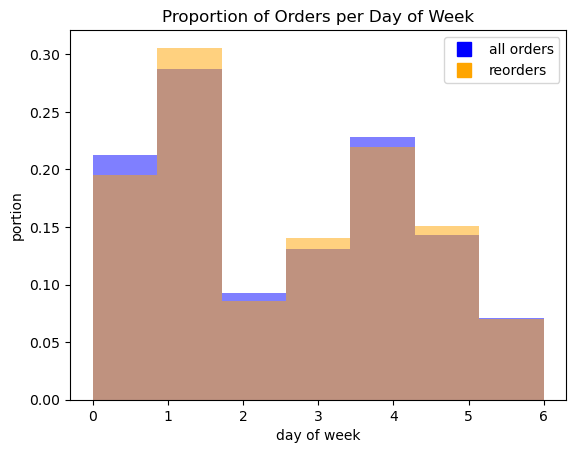

In [32]:
user_reordered = pu_unchanged[pu_unchanged['reordered']==1]

plt.hist(pu_unchanged['order_dow'], color='blue', density=True, alpha=0.5, bins=7)
plt.hist(user_reordered['order_dow'], color='orange', density=True, alpha=0.5, bins=7)
plt.title('Proportion of Orders per Day of Week')
plt.xlabel('day of week')
plt.ylabel('portion')
blue = mlines.Line2D([], [], color='blue', marker='s', linestyle='None', markersize=10, 
                       label='all orders')
orange = mlines.Line2D([], [], color='orange', marker='s', linestyle='None', markersize=10, 
                       label='reorders')
plt.legend(handles=[blue, orange]);

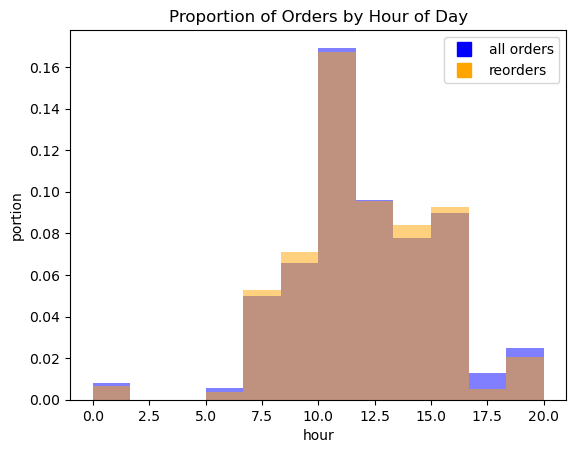

In [33]:
# In the overall df, dow changed little between reorders vs all orders This person seems similar. 

plt.hist(pu_unchanged['order_hour_of_day'], color='blue', density=True, alpha=0.5, bins=12)
plt.hist(user_reordered['order_hour_of_day'], color='orange', density=True, alpha=0.5, bins=12);
plt.title('Proportion of Orders by Hour of Day')
plt.xlabel('hour')
plt.ylabel('portion')
blue = mlines.Line2D([], [], color='blue', marker='s', linestyle='None', markersize=10, 
                       label='all orders')
orange = mlines.Line2D([], [], color='orange', marker='s', linestyle='None', markersize=10, 
                       label='reorders')
plt.legend(handles=[blue, orange]);

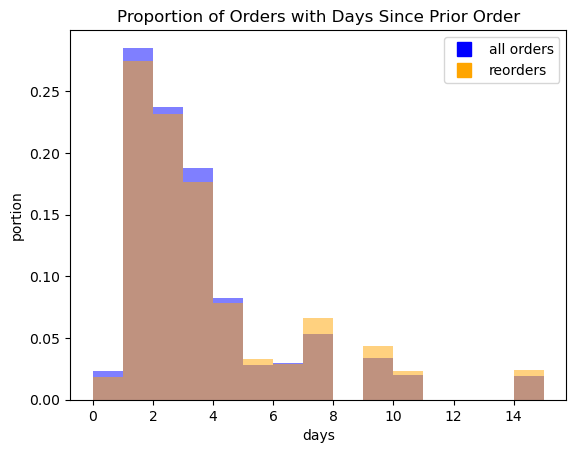

In [34]:
# In overall df, most people do most reordering from 7-10am This person has less of a pattern

plt.hist(pu_unchanged['days_since_prior_order'], color='blue', density=True, alpha=0.5, bins=15)
plt.hist(user_reordered['days_since_prior_order'], color='orange', density=True, alpha=0.5, 
         bins=15)
plt.title('Proportion of Orders with Days Since Prior Order')
plt.xlabel('days')
plt.ylabel('portion')
blue = mlines.Line2D([], [], color='blue', marker='s', linestyle='None', markersize=10, 
                       label='all orders')
orange = mlines.Line2D([], [], color='orange', marker='s', linestyle='None', markersize=10, 
                       label='reorders')
plt.legend(handles=[blue, orange]);

This person only has 15 days between orders at most, which makes sense because they're a major customer. Overall, it seemed more reorders happened within 10 days. This person seems not to reorder in the first 4 days, which makes a sort of sense (no need to reorder if you just got something, no time to have run out). And they include reorders at a relatively high rate even if it has been more than 10 days since their last order.  

In [35]:
pu_unchanged['add_to_cart_sequence'].max()

47

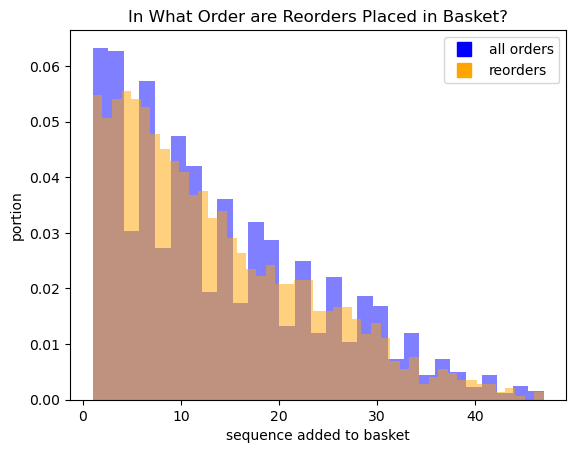

In [36]:
plt.hist(pu_unchanged['add_to_cart_sequence'], color='blue', density=True, alpha=0.5, bins=29)
plt.hist(user_reordered['add_to_cart_sequence'], color='orange', density=True, alpha=0.5, 
         bins=47)
plt.title('In What Order are Reorders Placed in Basket?')
plt.xlabel('sequence added to basket')
plt.ylabel('portion')
blue = mlines.Line2D([], [], color='blue', marker='s', linestyle='None', markersize=10, 
                       label='all orders')
orange = mlines.Line2D([], [], color='orange', marker='s', linestyle='None', markersize=10, 
                       label='reorders')
plt.legend(handles=[blue, orange]);

Most people put reorders in their basket first. This person seems to have a regular pattern of placing some new items in the basket first, following by reorders, then more new, then more reorders, etc. 

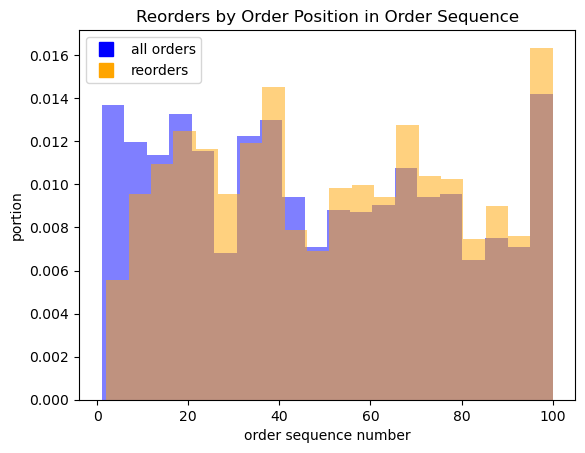

In [37]:
# Explore more of the order sequence.
plt.hist(pu_unchanged['order_by_user_sequence'], color='blue', density=True, alpha=0.5, bins=20)
plt.hist(user_reordered['order_by_user_sequence'], color='orange', density=True, alpha=0.5, 
         bins=20)
plt.title('Reorders by Order Position in Order Sequence')
plt.xlabel('order sequence number')
plt.ylabel('portion')
blue = mlines.Line2D([], [], color='blue', marker='s', linestyle='None', markersize=10, 
                       label='all orders')
orange = mlines.Line2D([], [], color='orange', marker='s', linestyle='None', markersize=10, 
                       label='reorders')
plt.legend(handles=[blue, orange]);

There is a similar trend here to the full df, with more reorders happening after more orders have been placed. But this person seems to have waited a bit longer before doing the bulk of their reordering. This person's behavior isn't grossly divergent from that of all users, though there are some differences. I'd like to do more exploration with this single user, and if I end up working with chunks of multiple users but not the entire df, I should make sure to try to find users whose behaviors reflect normal behavior, by choosing the users randomly.

**<font color='violet'>Use a DecisionTree to visualize one way how all this *could* be modeled.</font>**

In [38]:
# Get only the potentially useful, non-redundant columns. 

practice_user.columns

Index(['order_id', 'user_id', 'order_by_user_sequence', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'product_id',
       'add_to_cart_sequence', 'reordered', 'product_name', 'aisle_name',
       'dept_name', 'aisle_id', 'department_id', 'eval_set'],
      dtype='object')

In [39]:
pu_4models = practice_user.loc[:,['order_id', 'user_id', 'order_by_user_sequence', 
                            'order_dow', 'order_hour_of_day', 'days_since_prior_order', 
                            'product_id','add_to_cart_sequence', 'reordered', 'aisle_id',
                           'department_id']]
pu_4models.head(2)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,reordered,aisle_id,department_id
5261360,2959648,32099,1,0,17,NaN,40285,18.0,0.0,125.0,19.0
5261361,2959648,32099,1,0,17,NaN,27966,15.0,0.0,123.0,4.0


In [40]:
# Deal with remaining NaN values
pu_4models.isnull().any()

order_id                  False
user_id                   False
order_by_user_sequence    False
order_dow                 False
order_hour_of_day         False
days_since_prior_order     True
product_id                False
add_to_cart_sequence       True
reordered                 False
aisle_id                  False
department_id             False
dtype: bool

In [41]:
pu_4models['days_since_prior_order'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  9., 10., 15., nan])

In [42]:
# Not sure if this is the best option eventually, but for now I'm just trying to get every 
# field to be a number. Having a negative number in a place when the value is truly nan makes 
# some sort of sense. 

pu_4models['days_since_prior_order'] = pu_4models[
    'days_since_prior_order'].fillna(-1)
pu_4models['days_since_prior_order'].sort_values().unique()

array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  9., 10., 15.])

In [43]:
pu_4models['add_to_cart_sequence'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., nan])

In [44]:
# For add_to_cart_sequence, since no items originally had a value of 0, it seems to make sense to
# give the value of 0 to items that are never actually added to the cart. 

pu_4models['add_to_cart_sequence'] = pu_4models['add_to_cart_sequence'].fillna(0)
pu_4models['add_to_cart_sequence'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47.])

In [45]:
pu_4models.isnull().any()

order_id                  False
user_id                   False
order_by_user_sequence    False
order_dow                 False
order_hour_of_day         False
days_since_prior_order    False
product_id                False
add_to_cart_sequence      False
reordered                 False
aisle_id                  False
department_id             False
dtype: bool

In [46]:
# Get ind/dep variables.

y = pu_4models['reordered']
X = pu_4models.drop('reordered', axis=1)

X.head(2)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,aisle_id,department_id
5261360,2959648,32099,1,0,17,-1.0,40285,18.0,125.0,19.0
5261361,2959648,32099,1,0,17,-1.0,27966,15.0,123.0,4.0


In [47]:
y = y.array.reshape(-1,1)

In [48]:
# Model (expect massive problems from a modeling perspective, just trying to get a visual)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3)

clf = DecisionTreeClassifier(max_depth=5)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.confusion_matrix(y_test, y_pred)

array([[9656,  106],
       [  29,  416]])

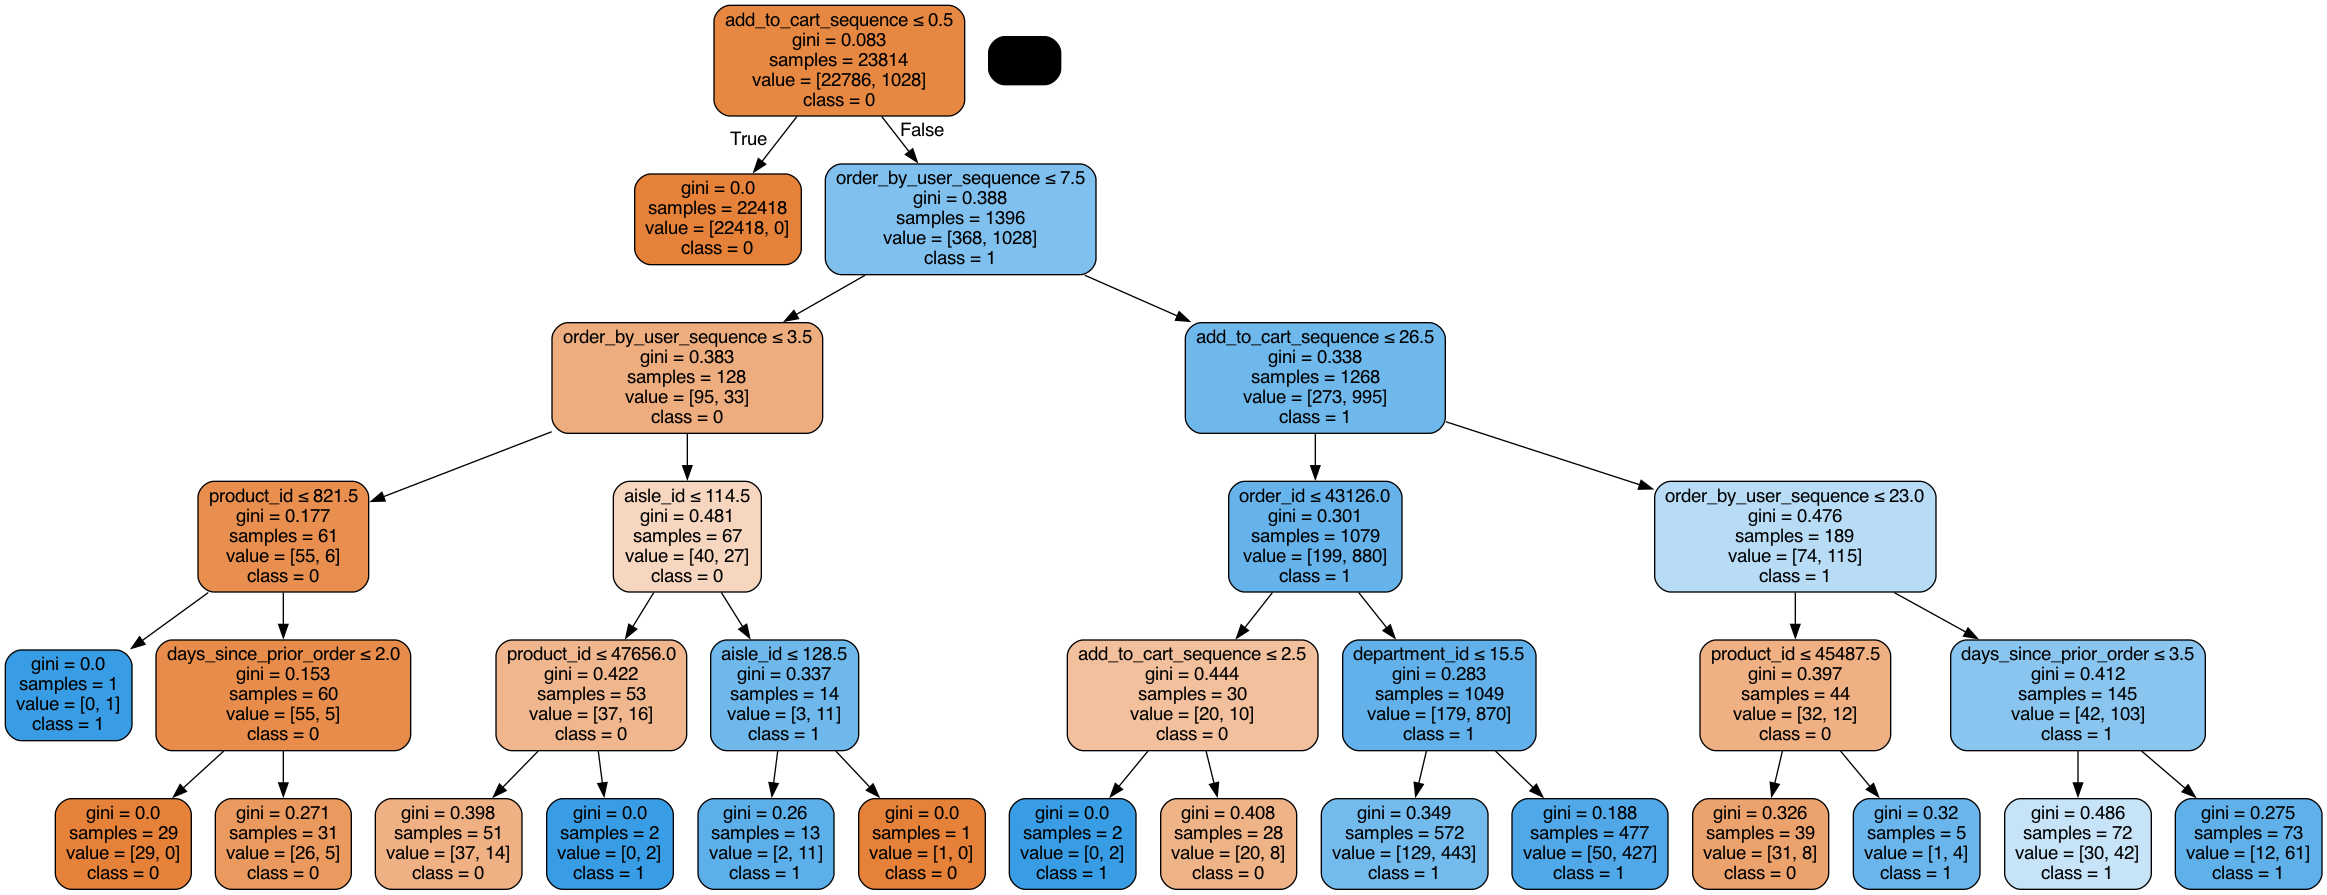

In [49]:
# Visualize tree

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, 
                special_characters=True, feature_names = X.columns, 
                class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('pu_4models.png')
Image(graph.create_png())

It looks like the order_by_user_sequence and add_to_cart_sequence are the features being used most to make decisions. And, for example, most samples classified as non-reorders occur with order_by_user_sequence <3.5. Plenty here is consistent with what the histograms showed. There are also tons of problems with this model, for example, unbalanced classes and categories being treated as ordinal just because their ids are integers. But it's been helpful in simply visualizing how a model could potentially shake out given existing data. 

In [50]:
# Save all the dictionaries in files that can be imported later Because they take a long time to
# load and re-make themselves. 

with open('../data/processed/dicts/prod_id_name_dict.txt', 'w') as convert_file:
     convert_file.write(json.dumps(prod_id_name_dict))

In [51]:
with open('../data/processed/dicts/aisle_id_name_dict.txt', 'w') as convert_file:
     convert_file.write(json.dumps(aisle_id_name_dict))

In [52]:
with open('../data/processed/dicts/dept_id_name_dict.txt', 'w') as convert_file:
     convert_file.write(json.dumps(dept_id_name_dict))

In [53]:
with open('../data/processed/dicts/prod_aisle_dict.txt', 'w') as convert_file:
     convert_file.write(json.dumps(prod_aisle_dict))

In [54]:
with open('../data/processed/dicts/aisle_dept_dict.txt', 'w') as convert_file:
     convert_file.write(json.dumps(aisle_dept_dict))

**<font color='violet'>Save the practice_user df to dig deeper in the next notebook* be modeled.</font>**

In [55]:
datapath = '../data/processed'
save_file(practice_user, 'practice_user.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../data/processed/practice_user.csv"


Next:
- Features need to be engineered with dummies and such to be more appropriate for modeling. Do that with the single user as the final step of EDA.
- I'll need to be working with some portion (which, I need to decide) of the original, full df. Generalize the row-creation procedure I used here on a dataset with more users, as transition into the preprocessing step. 

Note: I Attempted clustering products into sub-aisles, but this proved fairly fruitless and seems not to be worth the work/won't greatly improve predictions as far as I can tell. Throwaway notebook where I worked that out: https://github.com/fractaldatalearning/Capstone2/blob/main/notebooks/eda_trash_product_clusters.ipynb
- An alternative option would be to analyze product names and make some columns out of them: i.e. Organic column with 0/1 if "organic" appears in the product name. Do this as part of feature engineering in the next notebook.

Link to eda3 notebook for more work with this single user: https://github.com/fractaldatalearning/Capstone2/blob/main/notebooks/eda3_1user_modeling.ipynb